### 🔁 ¿Qué es la Recuperación Iterativa en RAG Agéntico?
Combina tanto Recuperación Iterativa como Auto-reflexión

✅ Definición:
La Recuperación Iterativa es una estrategia dinámica donde un agente de IA no se conforma con el primer lote de documentos recuperados. En su lugar, evalúa la adecuación del contexto inicial, y si es necesario:

- Refina la consulta,
- Recupera de nuevo,
- Repite el proceso hasta que tenga suficiente confianza para responder la pregunta original.

🧠 ¿Por qué usarlo?
En RAG estándar:

- Se realiza un solo paso de recuperación, y el LLM lo usa para responder.
- Si los documentos estaban incompletos o eran irrelevantes, la respuesta puede fallar.

En RAG Iterativo:

- El agente reflexiona sobre el contenido recuperado y la respuesta que produjo.
- Si no está seguro, puede refinar su búsqueda (como lo haría un investigador humano).

In [ ]:
# Importación del módulo os para interactuar con el sistema operativo (variables de entorno, rutas, etc.)
import os

# Importación de List desde typing para definir tipos de datos (listas tipadas)
from typing import List

# Importación de BaseModel desde pydantic para crear modelos de datos con validación automática
from pydantic import BaseModel

# Importación de init_chat_model para inicializar modelos de chat de diferentes proveedores
from langchain.chat_models import init_chat_model

# Importación de OpenAIEmbeddings para generar embeddings (representaciones vectoriales) usando la API de OpenAI
from langchain_openai import OpenAIEmbeddings

# Importación de Document, la clase base de LangChain para representar documentos con contenido y metadatos
from langchain.schema import Document

# Importación de FAISS, una biblioteca de Facebook para búsqueda eficiente de similitud en vectores
from langchain.vectorstores import FAISS

# Importación de TextLoader para cargar archivos de texto plano (.txt) como documentos
from langchain_community.document_loaders import TextLoader

# Importación de RecursiveCharacterTextSplitter para dividir textos largos en chunks (fragmentos) de manera recursiva
from langchain.text_splitter import RecursiveCharacterTextSplitter

# Importación de StateGraph para crear grafos de estado (flujos de trabajo con nodos y aristas)
# END es un marcador especial que indica el final del grafo
from langgraph.graph import StateGraph, END

In [ ]:
# Importación del módulo os para acceder a variables de entorno
import os

# Importación de init_chat_model para inicializar modelos de chat de diferentes proveedores
from langchain.chat_models import init_chat_model

# Importación de load_dotenv para cargar variables de entorno desde un archivo .env
from dotenv import load_dotenv

# Configuración de la variable de entorno OPENAI_API_KEY con el valor obtenido del archivo .env
# Esto permite autenticarse con la API de OpenAI
os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")

# Inicialización del modelo de lenguaje usando GPT-4o (optimizado) de OpenAI
# Este será el LLM principal para generar respuestas, reflexionar y refinar consultas
llm=init_chat_model("openai:gpt-4o")

In [ ]:
### Cargar e Incrustar Documentos

# Carga del archivo de texto "internal_docs.txt" usando TextLoader
# encoding="utf-8" asegura la correcta lectura de caracteres especiales y acentos
# .load() devuelve una lista de objetos Document con el contenido del archivo
docs = TextLoader("internal_docs.txt", encoding="utf-8").load()

# División de los documentos en chunks (fragmentos) más pequeños usando RecursiveCharacterTextSplitter
# chunk_size=500: cada fragmento tendrá aproximadamente 500 caracteres
# chunk_overlap=50: habrá una superposición de 50 caracteres entre fragmentos consecutivos (para mantener contexto)
chunks = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50).split_documents(docs)

# Creación de un vector store (base de datos vectorial) usando FAISS
# .from_documents() toma los chunks y genera embeddings usando OpenAIEmbeddings()
# FAISS indexa estos vectores para búsquedas rápidas de similitud semántica
vectorstore = FAISS.from_documents(chunks, OpenAIEmbeddings())

# Conversión del vector store en un retriever (recuperador)
# El retriever es la interfaz estándar para realizar búsquedas de documentos relevantes basadas en una consulta
retriever = vectorstore.as_retriever()

In [ ]:
### Definir el Estado del Agente

# Clase que define el estado del flujo de trabajo RAG con recuperación iterativa
# Hereda de BaseModel (Pydantic) para validación automática de tipos y datos
class IterativeRAGState(BaseModel):
    # question: la pregunta original del usuario (tipo string, campo obligatorio)
    question: str
    
    # refined_question: versión refinada de la pregunta para mejorar la recuperación
    # Por defecto es una cadena vacía ""
    # Se genera cuando la respuesta inicial es insuficiente
    refined_question: str = ""
    
    # retrieved_docs: lista de documentos recuperados del vector store
    # Por defecto es una lista vacía []
    # Se actualiza en cada iteración de recuperación
    retrieved_docs: List[Document] = []
    
    # answer: la respuesta generada por el LLM basándose en los documentos recuperados
    # Por defecto es una cadena vacía ""
    answer: str = ""
    
    # verified: indica si la respuesta ha sido verificada como completa y suficiente
    # Por defecto es False (no verificada)
    # Cambia a True cuando el LLM determina que la respuesta es satisfactoria
    verified: bool = False
    
    # attempts: contador de intentos de recuperación y generación de respuesta
    # Por defecto es 0, se incrementa en cada iteración
    # Se usa para limitar el número máximo de iteraciones
    attempts: int = 0


In [ ]:
### Nodo de Recuperación

# Función que recupera documentos relevantes del vector store
# Es inteligente: usa la pregunta refinada si existe, sino usa la pregunta original
def retrieve_docs(state: IterativeRAGState) -> IterativeRAGState:
    """
    Recupera documentos usando la pregunta refinada (si existe) o la pregunta original.
    Esto permite que iteraciones posteriores usen consultas mejoradas.
    """
    
    # Determina qué pregunta usar para la recuperación:
    # - Si refined_question tiene contenido (no vacío), usa esa versión mejorada
    # - Si refined_question está vacío, usa la pregunta original (question)
    # El operador 'or' retorna el primer valor verdadero (no vacío)
    query = state.refined_question or state.question
    
    # Invoca al retriever con la consulta seleccionada
    # Devuelve una lista de documentos similares semánticamente a la consulta
    docs = retriever.invoke(query)
    
    # Retorna una copia actualizada del estado con los documentos recuperados
    # .model_copy(update={...}) crea una nueva instancia del estado con campos actualizados
    return state.model_copy(update={"retrieved_docs": docs})


In [ ]:
### Generar Respuesta

# Función que genera una respuesta usando el LLM basándose en los documentos recuperados
def generate_answer(state: IterativeRAGState) -> IterativeRAGState:
    """
    Genera una respuesta usando el contexto de los documentos recuperados.
    Incrementa el contador de intentos para rastrear el número de iteraciones.
    """
    
    # Concatena el contenido de todos los documentos recuperados
    # Se unen con dos saltos de línea (\n\n) para separar claramente cada fragmento
    # Esto crea un contexto unificado y legible para el LLM
    context = "\n\n".join(doc.page_content for doc in state.retrieved_docs)
    
    # Construcción del prompt para el LLM
    # Incluye instrucciones claras, el contexto recuperado y la pregunta original
    prompt = f"""Usa el siguiente contexto para responder la pregunta:

Contexto:
{context}

Pregunta:
{state.question}
"""
    # Invocación del LLM con el prompt
    # .strip() elimina espacios en blanco al inicio y final del prompt
    # .content.strip() extrae el contenido de la respuesta y elimina espacios en blanco
    response = llm.invoke(prompt.strip()).content.strip()
    
    # Retorna el estado actualizado con:
    # - answer: la respuesta generada por el LLM
    # - attempts: el contador de intentos incrementado en 1
    return state.model_copy(update={"answer": response, "attempts": state.attempts + 1})

In [ ]:
## Reflexionar sobre la respuesta

# Función que evalúa si la respuesta generada es completa y suficiente
def reflect_on_answer(state: IterativeRAGState) -> IterativeRAGState:
    """
    Usa el LLM como juez para evaluar la calidad de la respuesta generada.
    Determina si la respuesta es factualmente suficiente y completa.
    """
    
    # Construcción del prompt de evaluación
    # Le pide al LLM que actúe como crítico de su propia respuesta
    prompt = f"""
Evalúa si la respuesta a continuación es factualmente suficiente y completa.

Pregunta: {state.question}
Respuesta: {state.answer}

Responde 'SÍ' si está completa, de lo contrario 'NO' con retroalimentación.
"""
    # Invocación del LLM con el prompt de evaluación
    # .content obtiene el texto de la respuesta
    # .lower() convierte todo a minúsculas para facilitar la comparación
    feedback = llm.invoke(prompt).content.lower()
    
    # Verifica si la palabra "yes" (o "sí" en minúsculas) está presente en la retroalimentación
    # verified será True si el LLM aprobó la respuesta, False si necesita más trabajo
    verified = "yes" in feedback
    
    # Retorna el estado actualizado con el campo verified
    # Este campo determina si el proceso debe continuar o terminar
    return state.model_copy(update={"verified": verified})


In [ ]:
## Refinar la consulta

# Función que refina la consulta original para mejorar la recuperación en la siguiente iteración
def refine_query(state: IterativeRAGState) -> IterativeRAGState:
    """
    Cuando la respuesta es insuficiente, esta función genera una versión mejorada
    de la consulta que debería recuperar información más relevante.
    """
    
    # Construcción del prompt de refinamiento
    # Le pide al LLM que sugiera una mejor versión de la consulta
    # basándose en lo que falta en la respuesta actual
    prompt = f"""
La respuesta parece incompleta. Sugiere una mejor versión de la consulta que ayudaría a recuperar un contexto más relevante.

Pregunta Original: {state.question}
Respuesta Actual: {state.answer}
"""
    # Invocación del LLM para generar la consulta refinada
    # .content.strip() extrae el texto y elimina espacios en blanco
    new_query = llm.invoke(prompt).content.strip()
    
    # Retorna el estado actualizado con la nueva consulta refinada
    # Esta consulta se usará en la próxima iteración de recuperación
    return state.model_copy(update={"refined_question": new_query})


In [ ]:
# Creación del constructor del grafo de estado usando la clase IterativeRAGState
# Este grafo implementa un ciclo de retroalimentación para recuperación iterativa
builder = StateGraph(IterativeRAGState)

# Agregado de nodos al grafo
# Cada nodo es una función que procesa y transforma el estado

# Nodo "retrieve": recupera documentos del vector store usando la consulta actual o refinada
builder.add_node("retrieve", retrieve_docs)

# Nodo "answer": genera una respuesta basándose en los documentos recuperados
builder.add_node("answer", generate_answer)

# Nodo "reflect": evalúa si la respuesta generada es suficiente y completa
builder.add_node("reflect", reflect_on_answer)

# Nodo "refine": genera una versión mejorada de la consulta si la respuesta fue insuficiente
builder.add_node("refine", refine_query)

# Establecer el punto de entrada del grafo (primer nodo a ejecutar)
# El flujo comienza con la recuperación de documentos
builder.set_entry_point("retrieve")

# Definición de aristas (edges) - conexiones entre nodos

# Después de "retrieve", siempre ir a "answer"
# Una vez recuperados los documentos, se genera una respuesta
builder.add_edge("retrieve", "answer")

# Después de "answer", siempre ir a "reflect"
# Una vez generada la respuesta, se evalúa su calidad
builder.add_edge("answer", "reflect")

# Arista condicional después de "reflect" - el corazón del patrón iterativo
# La función lambda decide el siguiente paso basándose en el estado:
# - Si verified=True (respuesta aprobada) O attempts>=2 (máximo de intentos) → ir a END (terminar)
# - Si verified=False (respuesta insuficiente) Y attempts<2 → ir a "refine" (mejorar y reintentar)
builder.add_conditional_edges(
    "reflect",
    lambda s: END if s.verified or s.attempts >= 2 else "refine"
)

# Después de "refine", volver a "retrieve"
# Esto crea el ciclo iterativo: refinar consulta → recuperar → responder → reflexionar → (repetir si necesario)
builder.add_edge("refine", "retrieve")

# Después de "answer", también hay una conexión a END
# Esto parece ser redundante dado el flujo anterior, pero mantiene compatibilidad
builder.add_edge("answer", END)

# Compilación del grafo para hacerlo ejecutable
# .compile() valida la estructura y optimiza el grafo final
graph = builder.compile()


In [ ]:
# Definición de la consulta del usuario
# Esta pregunta es intencionalmente vaga para demostrar la recuperación iterativa
# Pregunta sobre dos conceptos: "bucles de agentes" y "sistemas basados en transformers"
query = "bucles de agentes y sistemas basados en transformers?"

# Creación del estado inicial con solo la pregunta del usuario
# Los demás campos (refined_question, retrieved_docs, answer, verified, attempts) usarán sus valores por defecto
initial_state = IterativeRAGState(question=query)

# Invocación del grafo con el estado inicial
# .invoke() ejecuta todo el flujo iterativo:
# 1. Recupera documentos con la pregunta original
# 2. Genera una respuesta
# 3. Reflexiona sobre la calidad de la respuesta
# 4. Si no es suficiente, refina la consulta y vuelve al paso 1
# 5. Repite hasta que la respuesta sea satisfactoria o se alcance el límite de intentos
final = graph.invoke(initial_state)

# Impresión de la respuesta final generada después de todas las iteraciones
print("✅ Respuesta Final:\n", final["answer"])

# Impresión del estado de verificación: True si la respuesta fue aprobada, False si se agotaron los intentos
print("\n🧠 Verificada:", final["verified"])

# Impresión del número total de intentos realizados (máximo 2)
# Esto muestra cuántas iteraciones fueron necesarias para obtener una respuesta satisfactoria
print("🔁 Intentos:", final["attempts"])

In [ ]:
# Mostrar el estado final completo para inspección y depuración
# Esto incluye todos los campos: question, refined_question, retrieved_docs, answer, verified, attempts
final

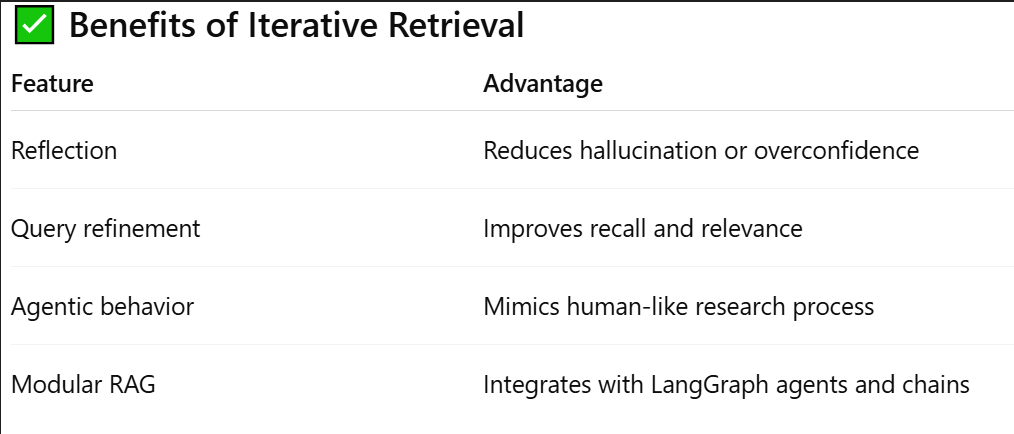